In [1]:
# ==== A) Setup & Paths ====
!pip -q install scikit-learn==1.3.2 xgboost==1.7.6 --no-cache-dir

from pathlib import Path
import os, json, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import calibration_curve

from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    pass  # ya montado

P11 = Path("/content/drive/MyDrive/CognitivaAI/p11_alt_backbones")
P14 = Path("/content/drive/MyDrive/CognitivaAI/p14_oasis2_images")
P16 = Path("/content/drive/MyDrive/CognitivaAI/p16_ensemble_refine")
P17 = Path("/content/drive/MyDrive/CognitivaAI/p17_ensemble_calibration")
P17.mkdir(parents=True, exist_ok=True)

VAL_FEATS  = P11/"val_patient_features_backbones.csv"
TEST_FEATS = P11/"test_patient_features_backbones.csv"

assert VAL_FEATS.exists() and TEST_FEATS.exists(), "No encuentro features de p11 (val/test)."
print("Rutas OK.")


Mounted at /content/drive
Rutas OK.


In [2]:
# ==== B) Load & Diagnose ====
val_df  = pd.read_csv(VAL_FEATS)
test_df = pd.read_csv(TEST_FEATS)

# Identificación de cohortes por prefijo (OAS1 / OAS2)
def cohort_of(pid:str) -> str:
    s = str(pid)
    if s.startswith("OAS2_") or s.startswith("OAS2"): return "OAS2"
    return "OAS1"

val_df["cohort"]  = val_df["patient_id"].map(cohort_of)
test_df["cohort"] = test_df["patient_id"].map(cohort_of)

# Columnas de entrada (excluimos ID/target/cohort)
exclude = {"patient_id","y_true","cohort"}
feat_cols = [c for c in val_df.columns if c not in exclude]

print(f"VAL: {val_df.shape} | TEST: {test_df.shape}")
print("Total feats detectadas:", len(feat_cols))

# Diagnóstico de NaNs (VAL)
nan_ratio = val_df[feat_cols].isna().mean().sort_values(ascending=False)
print("\nTop-10 NaN ratio (VAL):\n", nan_ratio.head(10))

# Regla: conservar columnas con NaN <= 0.40 (conservadora para aprovechar OAS1+OAS2)
KEEP_NAN_MAX = 0.40
keep_cols = [c for c in feat_cols if val_df[c].isna().mean() <= KEEP_NAN_MAX]
drop_cols = sorted(set(feat_cols) - set(keep_cols))
print(f"\n✅ Mantengo {len(keep_cols)} columnas; ❌ descarto por NaN>{KEEP_NAN_MAX}: {len(drop_cols)}")

X_val_raw, y_val = val_df[keep_cols].copy(), val_df["y_true"].astype(int).values
X_test_raw, y_test = test_df[keep_cols].copy(), test_df["y_true"].astype(int).values

# Cohorte counts
print("\nVAL cohort counts:", val_df["cohort"].value_counts().to_dict())
print("TEST cohort counts:", test_df["cohort"].value_counts().to_dict())


VAL: (69, 59) | TEST: (70, 59)
Total feats detectadas: 56

Top-10 NaN ratio (VAL):
 slices_preds_trimmed20              0.855072
patient_preds_trimmed20             0.855072
patient_preds_mean                  0.855072
patient_preds_ensemble_trimmed20    0.855072
patient_preds_ensemble_top7         0.855072
patient_preds_ensemble_p2           0.855072
patient_preds_ensemble_mean         0.855072
patient_preds_top7                  0.855072
patient_preds_p2                    0.855072
slices_preds_top7                   0.855072
dtype: float64

✅ Mantengo 36 columnas; ❌ descarto por NaN>0.4: 20

VAL cohort counts: {'OAS1': 47, 'OAS2': 22}
TEST cohort counts: {'OAS1': 47, 'OAS2': 23}


In [3]:
# ==== C) OOF Stacking ====
# Base learners (LR con imputación/escala, HGB nativo con NaNs)
base_lr = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"))
])
base_hgb = HistGradientBoostingClassifier(
    learning_rate=0.06, max_depth=None, max_iter=300, random_state=42
)

# OOF en VAL (para entrenar meta-learner sin fuga)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_lr  = np.zeros(len(X_val_raw))
oof_hgb = np.zeros(len(X_val_raw))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_val_raw, y_val), 1):
    Xtr, ytr = X_val_raw.iloc[tr_idx], y_val[tr_idx]
    Xva, yva = X_val_raw.iloc[va_idx], y_val[va_idx]

    # fit
    base_lr.fit(Xtr, ytr)
    base_hgb.fit(Xtr, ytr)

    # predict proba (clase positiva = 1)
    oof_lr[va_idx]  = base_lr.predict_proba(Xva)[:,1]
    oof_hgb[va_idx] = base_hgb.predict_proba(Xva)[:,1]

print("OOF listo: ", {"lr": oof_lr.shape, "hgb": oof_hgb.shape})

# Meta-features en VAL (OOF) y TEST (refit bases en full VAL → infer TEST)
meta_val = np.vstack([oof_lr, oof_hgb]).T

# Reentrenar bases en todo VAL y predecir TEST
base_lr.fit(X_val_raw, y_val)
base_hgb.fit(X_val_raw, y_val)
meta_test = np.vstack([
    base_lr.predict_proba(X_test_raw)[:,1],
    base_hgb.predict_proba(X_test_raw)[:,1]
]).T

print("meta_val:", meta_val.shape, "| meta_test:", meta_test.shape)


OOF listo:  {'lr': (69,), 'hgb': (69,)}
meta_val: (69, 2) | meta_test: (70, 2)


In [4]:
# ==== D) Meta-learner + Calibration ====
# 1) Meta-learner: LR sobre meta_val (OOF)
meta_lr = LogisticRegression(max_iter=2000, solver="lbfgs")
meta_lr.fit(meta_val, y_val)
val_meta_prob  = meta_lr.predict_proba(meta_val)[:,1]
test_meta_prob = meta_lr.predict_proba(meta_test)[:,1]

# 2) Platt scaling sobre salida meta (ajuste sigmoide p' = sigmoid(a*logit(p)+b))
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

class PlattScaler:
    def __init__(self):
        self.lr = LogisticRegression(max_iter=1000, solver="lbfgs")
        self.a_ = None; self.b_ = None
    def fit(self, p, y):
        z = logit(p)[:,None]  # 1D → 2D
        self.lr.fit(z, y)
        # extra: guardar a,b equivalentes si quieres documentar
        w = self.lr.coef_.ravel()[0]; b = self.lr.intercept_.ravel()[0]
        self.a_, self.b_ = w, b
        return self
    def predict_proba(self, p):
        z = logit(p)[:,None]
        return self.lr.predict_proba(z)[:,1]

platt = PlattScaler().fit(val_meta_prob, y_val)
val_cal = platt.predict_proba(val_meta_prob)
test_cal = platt.predict_proba(test_meta_prob)

# 3) (Opcional) Temperature scaling sobre logits meta (si quisieras afinar más)
def fit_temperature(p, y, T0=1.0, steps=200, lr=0.01):
    # minimiza NLL sobre logits/T
    z = logit(p)
    T = T0
    for _ in range(steps):
        # grad aproximado por derivada de NLL respecto a T
        q = 1/(1+np.exp(-z/T))
        grad = np.mean((q - y) * (z/(T**2)))
        T -= lr * grad
        T = max(0.1, min(10.0, T))
    return T

use_temp = False  # cambia a True si quieres añadir temperature scaling después de Platt
if use_temp:
    T = fit_temperature(val_cal, y_val, T0=1.0, steps=200, lr=0.05)
    def temp_apply(p):
        return 1/(1+np.exp(-logit(p)/T))
    val_cal = temp_apply(val_cal)
    test_cal = temp_apply(test_cal)
    print(f"Temperature fitted: T={T:.3f}")


In [5]:
# ==== E) Threshold tuning on VAL ====
def metrics(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    return dict(
        AUC = float(roc_auc_score(y_true, y_score)),
        PRAUC = float(average_precision_score(y_true, y_score)),
        Acc = float(accuracy_score(y_true, y_pred)),
        P = float(precision_score(y_true, y_pred, zero_division=0)),
        R = float(recall_score(y_true, y_pred, zero_division=0)),
        F1 = float(f1_score(y_true, y_pred, zero_division=0)),
        thr = float(thr),
        n = int(len(y_true))
    )

# Umbral ~ F1-max en VAL (grid fino)
grid = np.linspace(0.05, 0.95, 19)
best = (-1, None)  # (F1, thr)
for t in grid:
    m = metrics(y_val, val_cal, thr=t)
    if m["F1"] > best[0]:
        best = (m["F1"], t)
thr_star = best[1]
print(f"Umbral óptimo (VAL, F1-max): {thr_star:.2f}")

# Métricas agregadas (ALL y por cohorte)
def cohort_metrics(df_ids, y_true, y_score, thr):
    d = {}
    idx_oas1 = (df_ids["cohort"]=="OAS1").values
    idx_oas2 = (df_ids["cohort"]=="OAS2").values
    d["ALL"]  = metrics(y_true, y_score, thr)
    if idx_oas1.any():
        d["OAS1"] = metrics(y_true[idx_oas1], y_score[idx_oas1], thr)
    if idx_oas2.any():
        d["OAS2"] = metrics(y_true[idx_oas2], y_score[idx_oas2], thr)
    return d

val_sum  = cohort_metrics(val_df[["patient_id","cohort"]], y_val, val_cal, thr_star)
test_sum = cohort_metrics(test_df[["patient_id","cohort"]], y_test, test_cal, thr_star)

print("\n[VAL-Calibrated]", val_sum)
print("\n[TEST-Calibrated]", test_sum)


Umbral óptimo (VAL, F1-max): 0.35

[VAL-Calibrated] {'ALL': {'AUC': 0.7809847198641765, 'PRAUC': 0.7528547291747667, 'Acc': 0.7391304347826086, 'P': 0.6444444444444445, 'R': 0.9354838709677419, 'F1': 0.763157894736842, 'thr': 0.35, 'n': 69}, 'OAS1': {'AUC': 0.8444444444444443, 'PRAUC': 0.8289092638031297, 'Acc': 0.851063829787234, 'P': 0.782608695652174, 'R': 0.9, 'F1': 0.8372093023255814, 'thr': 0.35, 'n': 47}, 'OAS2': {'AUC': 0.3140495867768595, 'PRAUC': 0.41083916083916083, 'Acc': 0.5, 'P': 0.5, 'R': 1.0, 'F1': 0.6666666666666666, 'thr': 0.35, 'n': 22}}

[TEST-Calibrated] {'ALL': {'AUC': 0.7014802631578948, 'PRAUC': 0.6728140983065202, 'Acc': 0.6285714285714286, 'P': 0.5681818181818182, 'R': 0.78125, 'F1': 0.6578947368421052, 'thr': 0.35, 'n': 70}, 'OAS1': {'AUC': 0.7685185185185185, 'PRAUC': 0.7446525032408902, 'Acc': 0.6808510638297872, 'P': 0.6190476190476191, 'R': 0.65, 'F1': 0.6341463414634146, 'thr': 0.35, 'n': 47}, 'OAS2': {'AUC': 0.5, 'PRAUC': 0.5217391304347826, 'Acc': 0.52

In [6]:
# ==== F) Calibration curves, Brier & Save ====
# Brier
val_brier  = brier_score_loss(y_val,  val_cal)
test_brier = brier_score_loss(y_test, test_cal)
print(f"Brier (VAL)={val_brier:.4f} | (TEST)={test_brier:.4f}")

# Curvas de calibración (val/test) → CSV (para graficar después si quieres)
def calib_points(y, p, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins, strategy='uniform')
    return pd.DataFrame({"mean_pred":mean_pred, "frac_pos":frac_pos})

cal_val  = calib_points(y_val,  val_cal)
cal_test = calib_points(y_test, test_cal)
cal_val.to_csv(P17/"calibration_curve_val.csv", index=False)
cal_test.to_csv(P17/"calibration_curve_test.csv", index=False)

# Guardar preds por paciente
out_val = val_df[["patient_id","cohort","y_true"]].copy()
out_val["y_score"] = val_cal
out_test = test_df[["patient_id","cohort","y_true"]].copy()
out_test["y_score"] = test_cal

out_val.to_csv(P17/"p17_val_patient_preds_calibrated.csv", index=False)
out_test.to_csv(P17/"p17_test_patient_preds_calibrated.csv", index=False)

# Resumen JSON
summary = {
    "variant":"p17_stack+platt",
    "threshold_star": float(thr_star),
    "VAL": val_sum,
    "TEST": test_sum,
    "brier": {"VAL": float(val_brier), "TEST": float(test_brier)},
    "kept_features": keep_cols,
    "dropped_features_for_nan": drop_cols
}
with open(P17/"p17_calibration_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print("💾 Guardados en:", str(P17))


Brier (VAL)=0.1763 | (TEST)=0.2265
💾 Guardados en: /content/drive/MyDrive/CognitivaAI/p17_ensemble_calibration


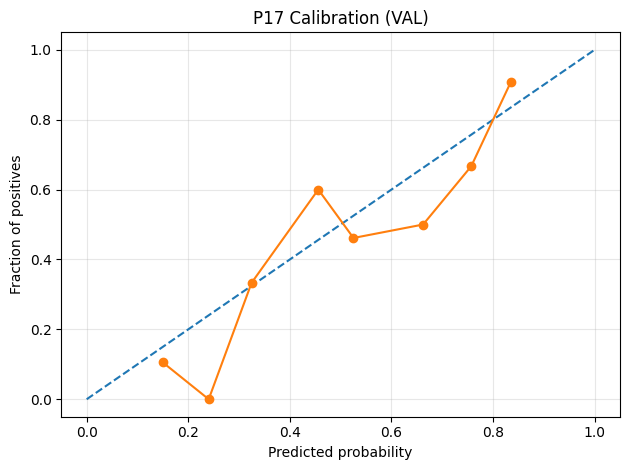

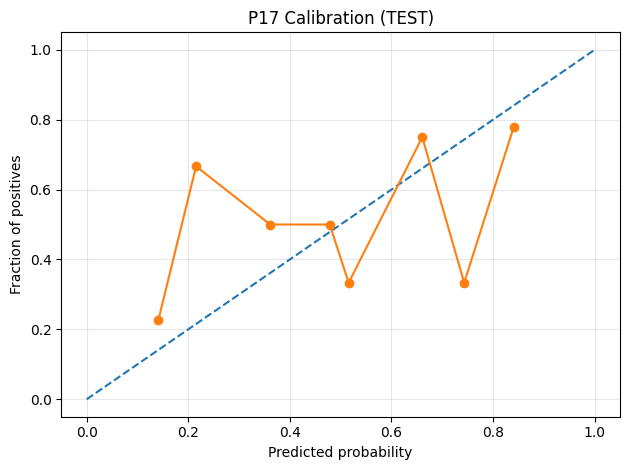


Checklist:
 - Stacking OOF sin fuga ✅
 - Meta LR + Platt scaling ✅
 - Umbral F1 en VAL y aplicado a TEST ✅
 - Brier y curvas de calibración guardadas ✅
 - Predicciones calibradas por paciente (VAL/TEST) ✅


In [7]:
# ==== G) Quick plots (opcional) ====
import matplotlib.pyplot as plt

def plot_calibration(df, title, path):
    plt.figure()
    plt.plot([0,1],[0,1], linestyle='--')
    plt.plot(df["mean_pred"], df["frac_pos"], marker='o')
    plt.title(title)
    plt.xlabel("Predicted probability")
    plt.ylabel("Fraction of positives")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(path, dpi=120)
    plt.show()

plot_calibration(pd.read_csv(P17/"calibration_curve_val.csv"),  "P17 Calibration (VAL)",  P17/"p17_calibration_val.png")
plot_calibration(pd.read_csv(P17/"calibration_curve_test.csv"), "P17 Calibration (TEST)", P17/"p17_calibration_test.png")

# Checklist final
print("\nChecklist:")
print(" - Stacking OOF sin fuga ✅")
print(" - Meta LR + Platt scaling ✅")
print(" - Umbral F1 en VAL y aplicado a TEST ✅")
print(" - Brier y curvas de calibración guardadas ✅")
print(" - Predicciones calibradas por paciente (VAL/TEST) ✅")
